# 타격 결과 예측 with Decision Tree

**Decision Tree**는 기계학습 방법 중에서 상대적으로 적은 양의 데이터셋으로도 좋은 결과를 얻을 수 있는 모델이다. 야구에서 타자가 친 타구의 결과가 어떠한지 예측하는 SVM 모델을 만들어보았다. 


- **1. [Importing MLB Data](#mlb-data)**
    - Pybaseball 라이브러리를 통해 21시즌 MLB Statcast 데이터를 불러왔다.
    - 모든 투구 데이터 중 타격이 이루어진 데이터를 추출하고, 예측에 사용할 독립변수(타구 속도, 타구 각도, 타구 거리, 각도)를 계산하고, 종속변수(아웃, 안타 or 홈런)를 numeric value로 분류하였다.
    
   
- **2. [Missing Data](#missing-data)**
    - Missing Data를 확인하고 이를 제거하였다.
       

- **3. [Formatting the Data for Decision Tree](#format-the-data)**
    - 데이터를 적절한 수로 downsampling하였다.
    - sampling된 데이터를 독립변수(X)와 종속변수(y)로 나누었다.
    - Decision Tree의 경우 종속 변수를 1루타, 2루타, 3루타, 홈런을 모두 나누는 multiclass가 아니라 아웃과 안타, 두가지로 분류하는 binary classification으로 진행하였다.
    - X와 y를 각각 모델을 학습시키는데 사용할 Train Data와 테스트하는데 사용할 Test Data로 분류하였다. 
    
          
- **4. [Building a Support Vector Machine](#build-dt)**
    - Train Data로 모델을 생성하였고, Test Data로 모델을 검증하였다.
    - 만들어진 Decision Tree를 시각화하였다.
    - Confusion Matrix로 모델 예측 결과를 시각화하였다.
     
        
- **5. [Opimizing Parameters with Cross Validation](#optimize-dt)**
    - 최적의 복잡도를 가진 Tree 구조를 찾아가는 Pruning 작업을 수행하였다.
    - Tree Score를 결정하는 Decision Tree 모델의 알파값을 Cross Validation 방식으로 최적화하였다.
    - 최적화한 모델이 기존 모델과 어떤 차이점이 있는지 시각화하고 비교 분석하였다.

    

In [100]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
from sklearn.utils import resample 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

<a id="mlb-data"></a>
# 1. Importing MLB Data

Pybaseball 라이브러리를 이용하여 21시즌 메이저리그 Statcast 데이터를 불러왔다. 모든 투구 데이터에서 타격이 이루어진 데이터(hit_into_play)를 추출하여 각 타구에 대한 결과를 예측

타구 속도, 타구 각도 데이터와 타구 거리 및 방향을 계산하여 총 4가지의 독립변수를 활용하였다. 종속변수는 타구 결과로서 아웃, 1루타, 2루타, 3루타, 홈런의 4가지로 구분할 수 있도록 분류하였다. 문자열로 구성된 타구 결과를 numeric value로 변경하기 위해 아웃은 0, 1루타는 1, 2루타는 2, 3루타는 3, 홈런은 4로 분류하였다.

### 1-1. 2021 시즌 MLB Statcast 데이터

In [2]:
total=pyb.statcast('2021-01-01', '2021-12-31')

This is a large query, it may take a moment to complete


  0%|          | 0/246 [00:00<?, ?it/s]

Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [02:44<00:00,  1.49it/s]


### 1-2. 모든 타석 결과 중 Hit_into_Play 데이터

In [48]:
hit_into_play = total[total['description']=='hit_into_play']

### 1-3. 모델을 학습시킬 독립변수와 종속변수

- **타구 결과를 예측할 수 있는 독립변수 = (타구 각도, 타구 속도, 타구 거리, 타구 방향)**
    - 타구 각도: launch_angle
    - 타구 속도: launch_speed
    - 타구 위치: hc_x, hc_y
        - 타구 거리: 홈플레이트에서 타구 위치까지의 거리 계산
        - 타구 각도: 홈플레이트 기준으로 hc_x, hc_y 사이의 각도 계산


- **종속변수 = (Out , Hit)**
    - 'out' = 0
    - 'hit' = 1

In [74]:
# 종속 변수 Column 'hit' 생성
hit = ['single', 'double', 'triple', 'home_run']
hit_into_play['hit'] = np.where(hit_into_play['events'].isin(hit), 1, 0)

# 학습에 필요한 독립 변수들만 추출
df = hit_into_play[['launch_angle', 'launch_speed', 'hc_x', 'hc_y', 'hit']]

In [75]:
# 홈플레이트 좌표를 이용하여 타구 거리와 각도 계산
home_x = 126
home_y = 204.111
df['distance'] = np.sqrt((df['hc_x']-home_x)**2 + (df['hc_y']-home_y)**2)
df['angle'] = df['distance']/(home_y-df['hc_y'])

In [76]:
df.head()

,launch_angle,launch_speed,hc_x,hc_y,hit,distance,angle
110,-28,93.8,98.12,136.43,0,73.198444,1.081521
134,39,92.7,68.50,86.79,0,130.653997,1.113645
178,24,93.1,173.40,72.81,0,139.594816,1.063166
212,13,103.4,175.56,102.42,1,113.124945,1.112438
186,-13,78.5,159.51,167.83,0,49.388572,1.361279


----

<a id="missing-data"></a>
# 2. Missing Value

데이터 중 기록되지 않은 missing value를 처리하였다. 위에서 추출한 데이터 총 123542개 중에서 각 변수들의 missing value는 400개 이하로 0.3%정도 되기 때문에 삭제하였다.

In [77]:
# 총 데이터 수
len(df)

123542

In [78]:
# missing value 수
df.isnull().sum()

launch_angle    392
launch_speed    391
hc_x             83
hc_y             83
hit               0
distance         83
angle            83
dtype: int64

In [79]:
# drop missing value
df = df[df['launch_angle'].notnull() & df['launch_speed'].notnull() & df['distance'].notnull() & df['angle'].notnull()]

In [91]:
# drop non-independent variable
df.drop(['hc_x', 'hc_y'], axis=1, inplace=True)

----

<a id="format-the-data"></a>
# 3. Formatting the Data for Support Vector Machines

Overfitting 예방과 적절한 모델 학습 시간을 위해 데이터를 downsampling을 수행하였다. 타구 결과가 아웃인 데이터 1000개, 타구 결과가 안타(1루타, 2루타, 3루타, 홈런 모두 포함)인 데이터 1000개를 랜덤 추출하였다.(총 2000개의 데이터)

downsampling으로 추출한 데이터를 학습에 사용할 데이터(Train Data)와 검증에 사용할 데이터(Test Data)로 구분하였다. SVM과 달리 Decision Tree 모델은 데이터 스케일링 작업이 필요하지 않아 스케일링 처리 단계는 삭제하였다.

### 3-1. Downsampling

In [92]:
df_out = df[df['hit']==0]
df_hit = df[df['hit']==1]

In [101]:
df_out_downsampled = resample(df_out,replace=False,n_samples=1000,random_state=42)
df_hit_downsampled = resample(df_hit,replace=False,n_samples=1000,random_state=42)

In [102]:
df_sample = pd.concat([df_out_downsampled, df_hit_downsampled])
len(df_sample)

2000

### 3-2. Split Data into Dependent and Independent Variables

In [106]:
# 독립변수 X, 종속변수 y
X = df_sample.drop('hit', axis=1).copy()
y = df_sample['hit'].copy()

In [107]:
# Train Data, Test Data 구분 및 데이터 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

----

<a id="build-dt"></a>
# 4. Building a Decision Tree

위에서 만든 학습에 사용할 종속변수와 독립변수 데이터(X_train, y_train)를 이용하여 DecisionTree 모델을 학습시켰다. 학습시킨 후 테스트 데이터(X_test, y_test)를 모델에 적용시켜 결과를 확인해보았다. 결과 확인은 confusion matrix를 이용하여 모델의 정확성을 확인하였고, Tree 모델을 시각화하여 모델의 복잡도를 확인하였다. 

모델의 예측 결과를 보면, 실제 아웃이 된 데이터 257개 중 207개를 제대로 예측하였고, 실제 안타가 된 데이터 243개 중 207개를 안타로 제대로 예측해서 꽤 준수한 예측 결과를 보여주었다. 시각화된 Tree 구조를 보면 꽤나 복잡하게 생성된 것을 볼 수 있는데, 5번 과정에서 Pruning을 통해 최적의 복잡도를 가진 Tree 구조를 찾아가는 작업을 수행하였다.

### 4-1. Training Model using Training Data

In [109]:
# building model
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

### 4-2. Tree Visualization

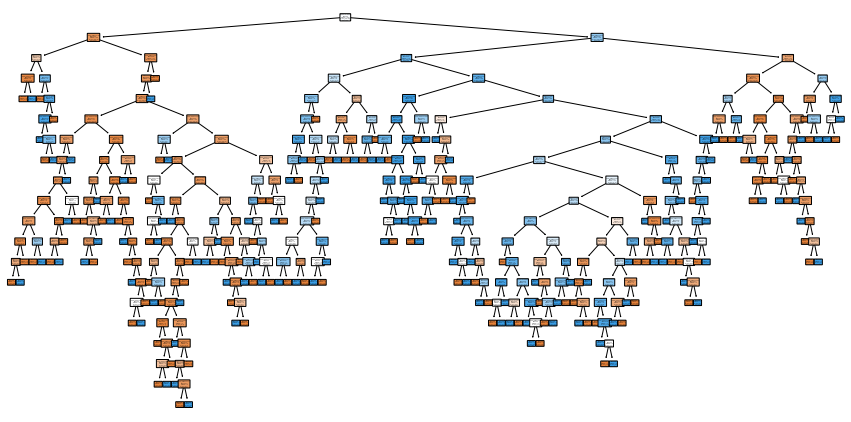

In [110]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, filled=True, rounded=True, class_names=['OUT', 'HIT'], feature_names=X_train.columns)
plt.show()

### 4-3. Testing Data

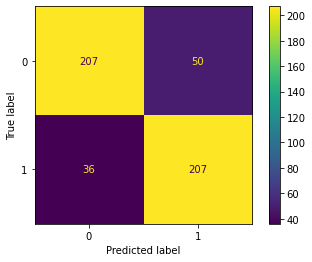

In [111]:
# confusion matrix로 결과 확인
plot_confusion_matrix(clf_dt, X_test, y_test)

----

<a id="optimize-dt"></a>
# 5. Opimizing Parameters with Cross Validation

Decision Tree에서 Tree를 가능한 세분화해서 복잡한 구조를 가지도록 만드는 것은 좋은 방법이 아니다. 복잡한 구조의 Tree 모델은 Training Data에서 굉장히 좋은 성능을 보여주지만 Test Data에서는 좋지 않은 성능을 보여준다. 이를 오버피팅이라고 하는데, 오버피팅을 방지하기 위해서 Tree의 복잡도를 줄여야 한다. 그렇다고 너무 간단한 구조의 Tree는 학습이 제대로 이루어지지 않아서 Training Data와 Testing Data 모두의 예측 성능이 좋지 않다. 그렇다면 어느정도 복잡도가 적당한 것일까?

Decision Tree에서 적절한 복잡도를 찾아가는 것을 Pruning이라고 한다. Tree들의 복잡도마다 각각 Tree Score를 계산하여 가장 낮은 Score를 가진 복잡도를 최적의 복잡도로써 결정한다. Tree Score는 ( SSR + $\alpha$ * T )로 계산되는데, 여기서 SSR은 오차 제곱의 합, T는 Tree Leaves의 수, $\alpha$는 Tuning parameter이다. $\alpha$ * T 는 복잡도 penalty라고 부르는데, Leaves의 수가 증가할수록(복잡도가 커질수록) penalty가 커져서 score가 커지게 된다. T는 Leaves의 수(상수)이기 때문에 penalty의 크기를 결정하는 것은 사실상 $\alpha$이고, $\alpha$가 변함에 따라 가장 낮은 score를 가지는 복잡도 Tree가 변하게 된다. 

최적의 $\alpha$ 값을 얻은 후에 이를 Decision Tree에 새롭게 적용하여 다시 test data로 검증해보았다. 최적화된 Decision Tree와 기존 Tree와의 차이점을 살펴보면 OUT에 대한 예측이 좋아진 것을 확인할 수 있다. 기존에는 총 257개의 OUT 중 207개를 정확하게 예측한 반면, 최적화 후에는 232개를 정확하게 예측할 수 있었다. Tree의 복잡도를 시각화한 구조를 살펴보면 기존과 큰 차이를 확인할 수 있다. 복잡도가 훨씬 간단해진 것에 비해 예측 성능은 더 좋아졌기 때문에, Pruning 작업이 효과적이었다는 것을 알 수 있다.

In [112]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)

In [113]:
# 가장 복잡한 구조의 
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

In [119]:
clf_dts = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

In [120]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

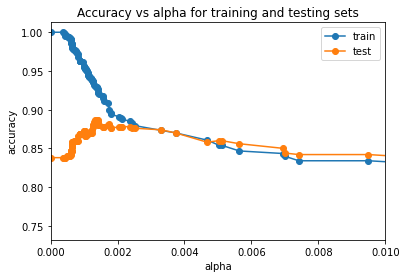

In [130]:
fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs alpha for training and testing sets')
ax.plot(ccp_alphas, train_scores, marker='o', label='train')
ax.plot(ccp_alphas, test_scores, marker='o', label='test')
ax.legend()
plt.xlim(0,0.01)
plt.show()

<AxesSubplot:xlabel='tree'>

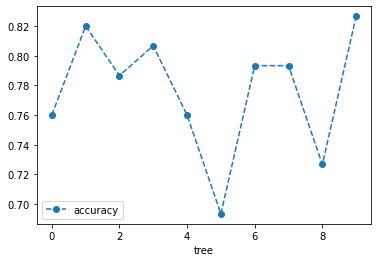

In [152]:
# 알파에 따라 

clf_df = DecisionTreeClassifier(random_state=42, ccp_alpha=0.002)

scores = cross_val_score(clf_dt, X_train, y_train, cv=10)

df = pd.DataFrame(data={'tree': range(10), 'accuracy': scores})
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

(0.0, 0.01)

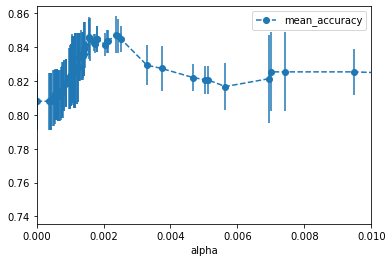

In [148]:
# 평균적으로 제일 높은 정확도를 보여주는 최적의 알파 찾기(ideal_alpha)

alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle = '--')
plt.xlim(0,0.01)

In [141]:
alpha_results[(alpha_results['alpha']> 0.002) & (alpha_results['alpha']<0.003)]

,alpha,mean_accuracy,std
81,0.002055,0.841333,0.006864
82,0.002097,0.843333,0.006667
83,0.002141,0.843333,0.006667
84,0.002360,0.847333,0.010832
85,0.002425,0.846667,0.010111
86,0.002524,0.844667,0.007483


In [142]:
ideal_alpha = alpha_results[(alpha_results['alpha']> 0.002) & (alpha_results['alpha']<0.003)].sort_values(by='mean_accuracy', ascending=False)['alpha'].iloc[0]

In [143]:
# Test Data로 최적화된 모델 검증
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

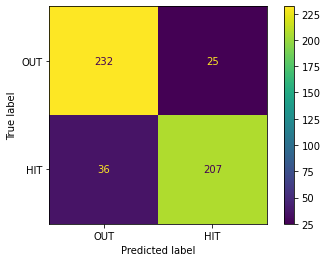

In [144]:
plot_confusion_matrix(clf_dt_pruned, X_test, y_test, display_labels=['OUT', 'HIT'])

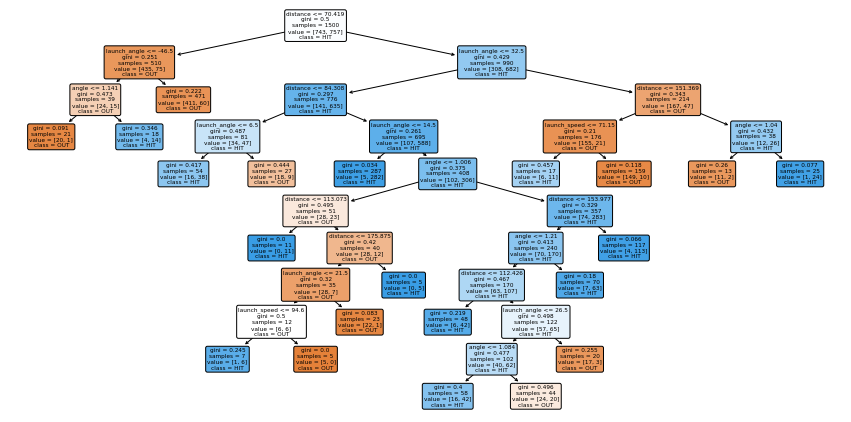

In [145]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt_pruned, filled=True, rounded=True, class_names=['OUT', 'HIT'], feature_names=X_train.columns)
plt.show()

----

----